# BESS Simulation in Long-Term

Here we want to perform the multi-market optimization with the hourly resolution but for the long-duration of the time (e.g. 15 years)

## Scneario 1: with constant cycle cost


In [113]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd





# Function to run the optimization model for a given month
def run_model_for_month(df_lambda, start_date, end_date, Gmax_disch, soc_min, soc_max, soc_init, delta_FFR, delta_FCR_N, delta_FCR_D,spot_active,FCRD_future,FCRN_future,cycle_cost,etta,mFRR_CM_future, mFRR_EAM_future, aFRR_CM_future,FFR_future):
    # Filter the data based on the start and end dates
    df_lambda_month = df_lambda[(df_lambda['Date'] >= start_date) & (df_lambda['Date'] <= end_date)]
    
    # Update the tMax based on the filtered data
    tMax = len(df_lambda_month)
    
    # Create a time index based on the filtered data
    time_index = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # Create a dictionary for Gmax_ch based on the conditions
    Gmax_ch_dict = {}
    for dt in time_index:
        if (4 <= dt.month <= 10) or (22 <= dt.hour or dt.hour < 6) or (dt.weekday() == [5,6]):
            Gmax_ch_dict[dt] = Gmax_disch
        else:
            Gmax_ch_dict[dt] = Gmax_disch

    # Map integer time index to datetime objects
    time_index_mapping = {i: dt for i, dt in enumerate(time_index)}

    # define a set of time periods and parameters
    model = ConcreteModel()
    model.T = Set(initialize=range(tMax))
    model.T_order = Set(initialize=time_index, ordered=True)
    model.tamx = Param(initialize=tMax)
    model.Gmax_disch = Param(initialize=Gmax_disch)
    model.Gmax_ch_dict = Param(model.T_order, initialize=Gmax_ch_dict)
    model.soc_min = Param(initialize=soc_min)
    model.soc_max = Param(initialize=soc_max)
    model.delta_FFR = Param(initialize=delta_FFR)
    model.delta_FCR_N = Param(initialize=delta_FCR_N)
    model.delta_FCR_D = Param(initialize=delta_FCR_D)
    model.soc_init = Param(initialize=soc_init)
    model.etta_disch = Param(initialize=etta)
    model.etta_ch = Param(initialize=etta)

    def Gmax_ch_rule(model, t):
        dt = time_index_mapping[t]
        return Gmax_ch_dict[dt]
    model.Gmax_ch = Param(model.T, initialize=Gmax_ch_rule, within=NonNegativeReals)

    # Extract the relevant columns
    lambda_FFR = df_lambda_month['FFR Pris (EUR/MW)'].to_list()
    lambda_FCR_N = df_lambda_month['FCR-N Pris (EUR/MW)'].to_list()
    lambda_FCR_D_up = df_lambda_month['FCR-D upp Pris (EUR/MW)'].to_list()
    lambda_FCR_D_down = df_lambda_month['FCR-D ned Pris (EUR/MW)'].to_list()
    lambda_aFRR_CM_up = df_lambda_month['aFRR Upp Pris (EUR/MW)'].to_list()
    lambda_aFRR_CM_down = df_lambda_month['aFRR Ned Pris (EUR/MW)'].to_list()
    lambda_mFRR_CM_up = df_lambda_month['mFRR Upp Pris (EUR/MW)'].to_list()
    lambda_mFRR_CM_down = df_lambda_month['mFRR Ned Pris (EUR/MW)'].to_list()
    lambda_mFRR_EAM_up = df_lambda_month['mFRR Upp EAM Pris (EUR/MW)'].to_list()
    lambda_mFRR_EAM_down = df_lambda_month['mFRR Ned EAM Pris (EUR/MW)'].to_list()
    lambda_spot = df_lambda_month['SPOT'].to_list()

    # Create dictionaries for initialization
    lambda_FFR_dict = {t: lambda_FFR[t] for t in model.T}
    lambda_FCR_N_dict = {t: lambda_FCR_N[t] for t in model.T}
    lambda_FCR_D_up_dict = {t: lambda_FCR_D_up[t] for t in model.T}
    lambda_FCR_D_down_dict = {t: lambda_FCR_D_down[t] for t in model.T}
    lambda_aFRR_CM_up_dict = {t: lambda_aFRR_CM_up[t] for t in model.T}
    lambda_aFRR_CM_down_dict = {t: lambda_aFRR_CM_down[t] for t in model.T}
    lambda_mFRR_CM_up_dict = {t: lambda_mFRR_CM_up[t] for t in model.T}
    lambda_mFRR_CM_down_dict = {t: lambda_mFRR_CM_down[t] for t in model.T}
    lambda_mFRR_EAM_up_dict = {t: lambda_mFRR_EAM_up[t] for t in model.T}
    lambda_mFRR_EAM_down_dict = {t: lambda_mFRR_EAM_down[t] for t in model.T}
    lambda_spot_dict = {t: lambda_spot[t] for t in model.T}


    # Define the Params in the model
    model.lambda_FFR = Param(model.T, initialize=lambda_FFR_dict)
    model.lambda_FCR_N = Param(model.T, initialize=lambda_FCR_N_dict)
    model.lambda_FCR_D_up = Param(model.T, initialize=lambda_FCR_D_up_dict)
    model.lambda_FCR_D_down = Param(model.T, initialize=lambda_FCR_D_down_dict)
    model.lambda_aFRR_CM_up = Param(model.T, initialize=lambda_aFRR_CM_up_dict)
    model.lambda_aFRR_CM_down = Param(model.T, initialize=lambda_aFRR_CM_down_dict)
    model.lambda_mFRR_CM_up = Param(model.T, initialize=lambda_mFRR_CM_up_dict)
    model.lambda_mFRR_CM_down = Param(model.T, initialize=lambda_mFRR_CM_down_dict)
    model.lambda_mFRR_EAM_up = Param(model.T, initialize=lambda_mFRR_EAM_up_dict)
    model.lambda_mFRR_EAM_down = Param(model.T, initialize=lambda_mFRR_EAM_down_dict)
    model.lambda_spot = Param(model.T, initialize=lambda_spot_dict)

    # Define binary decision variables
    model.u_disch = Var(model.T, domain=Binary)
    model.u_ch = Var(model.T, domain=Binary)

    # Define continuous decision variables
    model.p_FFR_disch = Var(model.T, domain=NonNegativeReals)
    # fix p_FF_disch to zero
    model.p_FFR_disch.fix(0)
    model.p_FCR_N = Var(model.T, domain=NonNegativeReals)
    #model.p_FCR_N_ch = Var(model.T, domain=NonNegativeReals)
    model.p_FCR_D_up = Var(model.T, domain=NonNegativeReals)
    model.p_FCR_D_down = Var(model.T, domain=NonNegativeReals)
    model.p_aFRR_CM_up = Var(model.T, domain=NonNegativeReals)
    model.p_aFRR_CM_down = Var(model.T, domain=NonNegativeReals)
    model.p_mFRR_CM_up = Var(model.T, domain=NonNegativeReals)
    model.p_mFRR_CM_down = Var(model.T, domain=NonNegativeReals)
    model.p_mFRR_EAM_up = Var(model.T, domain=NonNegativeReals)
    model.p_mFRR_EAM_down = Var(model.T, domain=NonNegativeReals)

    model.p_spot_ch = Var(model.T, domain=NonNegativeReals)
    model.p_spot_disch = Var(model.T, domain=NonNegativeReals)
    model.soc = Var(model.T, domain=NonNegativeReals)
    model.cycle_number = Var(model.T, domain=NonNegativeReals)

    # Define the parameters
    model.spot_active = Param(initialize=spot_active)
    model.mFRR_CM_future = Param(initialize=mFRR_CM_future)
    model.mFRR_EAM_future = Param(initialize=mFRR_EAM_future)
    model.aFRR_CM_future = Param(initialize=aFRR_CM_future)
    model.cycle_cost = Param(initialize=cycle_cost)
    model.FCRD_future = Param(initialize=FCRD_future)
    model.FCRN_future = Param(initialize=FCRN_future)
    model.FFR_future = Param(initialize=FFR_future)

    if model.mFRR_CM_future == 0:
        model.p_mFRR_CM_up.fix(0)
        model.p_mFRR_CM_down.fix(0)
    if model.mFRR_EAM_future == 0:
        model.p_mFRR_EAM_up.fix(0)
        model.p_mFRR_EAM_down.fix(0)
    if model.aFRR_CM_future == 0:
        model.p_aFRR_CM_up.fix(0)
        model.p_aFRR_CM_down.fix(0)
    if model.spot_active == 0:
        model.p_spot_ch.fix(0)
        model.p_spot_disch.fix(0)
    if model.FFR_future == 0:
        model.p_FFR_disch.fix(0)


    ## Define the objective function
    model.obj = Objective(expr=sum(model.lambda_spot[t]*(model.p_spot_disch[t]- model.p_spot_ch[t])*model.spot_active
                                   + model.lambda_FCR_N[t]*model.p_FCR_N[t]*model.FCRN_future 
                                   + model.lambda_FFR[t]*model.p_FFR_disch[t]* model.FFR_future
                                   + model.lambda_FCR_D_down[t]*model.p_FCR_D_down[t]*model.FCRD_future             # capacity payment for FCR_D_down
                                   - model.p_FCR_D_down[t]*model.delta_FCR_D* model.lambda_spot[t]# energy payment for FCR_D_down
                                   + model.p_FCR_D_up[t]*model.delta_FCR_D* model.lambda_spot[t] # energy payment for FCR_D_up
                                   + model.lambda_FCR_D_up[t]*model.p_FCR_D_up[t]*model.FCRD_future 
                                   + model.lambda_aFRR_CM_up[t]*model.p_aFRR_CM_up[t]*model.aFRR_CM_future # capacity payment for aFRR_CM_up
                                   + model.lambda_aFRR_CM_down[t]*model.p_aFRR_CM_down[t]*model.aFRR_CM_future # capacity payment for aFRR_CM_down
                                   + model.lambda_mFRR_CM_up[t]*model.p_mFRR_CM_up[t]*model.mFRR_CM_future  # capacity payment for mFRR_CM_up
                                   + model.lambda_mFRR_CM_down[t]*model.p_mFRR_CM_down[t]*model.mFRR_CM_future  # capacity payment for mFRR_CM_down
                                   + model.lambda_mFRR_EAM_up[t]*model.p_mFRR_EAM_up[t]*model.mFRR_EAM_future  # capacity payment for mFRR_EAM_up 
                                   - model.lambda_mFRR_EAM_down[t]*model.p_mFRR_EAM_down[t]*model.mFRR_EAM_future  # capacity payment for mFRR_EAM_down
                                   - model.cycle_cost*model.cycle_number[t] for t in model.T), sense=maximize) # capacity payment for FCR_D_up
    



    ## Define the constraints

    # SOC update constraint
    def soc_update_rule(model, t):
        if t == 0:
            return model.soc[t] == model.soc_init
        else:
            soc_disch = (model.p_FFR_disch[t]*model.delta_FFR + model.p_FCR_N[t]*model.delta_FCR_N +
                          model.p_FCR_D_up[t] * model.delta_FCR_D + model.p_spot_disch[t]
                          + model.p_mFRR_EAM_up[t]) / model.etta_disch
            soc_ch = (model.p_FCR_N[t]*model.delta_FCR_N + model.p_FCR_D_down[t]*model.delta_FCR_D +
                      model.p_mFRR_EAM_down[t] + model.p_spot_ch[t]) * model.etta_ch
            return model.soc[t] == model.soc[t-1] + soc_ch - soc_disch
    model.soc_update = Constraint(model.T, rule=soc_update_rule)

    # Cycle number calculation
    def cycle_cost_rule(model, t):
        return model.cycle_number[t] == (model.p_FCR_N[t]*model.delta_FCR_N + model.p_FCR_D_down[t]*model.delta_FCR_D + model.p_spot_ch[t]
        + model.p_FFR_disch[t]*model.delta_FFR + model.p_FCR_N[t]*model.delta_FCR_N + model.p_FCR_D_up[t] * model.delta_FCR_D + model.p_spot_disch[t] + model.p_mFRR_EAM_down[t]+ model.p_mFRR_EAM_up[t])#/(model.soc_max-model.soc_min)
    model.cycle_cost_cons = Constraint(model.T, rule=cycle_cost_rule)

    # Capacity constraints
    def ch_power_limit_rule(model, t):
        return model.p_FCR_N[t] + model.p_FCR_D_down[t] + model.p_spot_ch[t] + model.p_aFRR_CM_down[t] + model.p_mFRR_CM_down[t]<= model.Gmax_ch[t]
    model.ch_power_limit = Constraint(model.T, rule=ch_power_limit_rule)

    def disch_power_limit_rule(model, t):
        return model.p_FFR_disch[t] + model.p_FCR_N[t] + model.p_FCR_D_up[t] + model.p_spot_disch[t]+ model.p_aFRR_CM_up[t] + model.p_mFRR_CM_up[t]<= model.Gmax_disch
    model.disch_power_limit = Constraint(model.T, rule=disch_power_limit_rule)

    # Reserve constraints for mFRR_CM and mFRR_EAM
    def cap_rule_mFRR_CM_up(model, t):
        return model.p_mFRR_CM_up[t] <= model.p_mFRR_EAM_up[t]    
    model.reserve_rule_mFRR_CM_up = Constraint(model.T, rule=cap_rule_mFRR_CM_up)

    def cap_rule_mFRR_CM_down(model, t):
        return model.p_mFRR_CM_down[t] <= model.p_mFRR_EAM_down[t]
    model.reserve_rule_mFRR_CM_down = Constraint(model.T, rule=cap_rule_mFRR_CM_down)

    def cap_rule_mFRR_EAM_up(model, t):
        return model.p_mFRR_EAM_up[t] <= model.Gmax_disch
    model.reserve_rule_mFRR_EAM_up = Constraint(model.T, rule=cap_rule_mFRR_EAM_up)

    def cap_rule_mFRR_EAM_down(model, t):
        return model.p_mFRR_EAM_down[t] <= model.Gmax_ch[t]
    model.reserve_rule_mFRR_EAM_down = Constraint(model.T, rule=cap_rule_mFRR_EAM_down)


    # NEM reserve constraints based on the SVK prequalification process
    def cap_rule_NEM_up(model, t):
        return 1.34*(model.p_FCR_N[t])+ 1*model.p_FCR_D_up[t] + 0.2*model.p_FCR_D_down[t]  <= Gmax_disch
    model.reserve_rule_fcr_nem_up = Constraint(model.T, rule=cap_rule_NEM_up)

    def cap_rule_NEM_down(model, t):
        return 1.34*(model.p_FCR_N[t])+ 0.2*model.p_FCR_D_up[t] + 1*model.p_FCR_D_down[t]  <= model.Gmax_ch[t]
    model.reserve_rule_fcr_nem_down = Constraint(model.T, rule=cap_rule_NEM_down)

    # Enery balance constraint
    def soc_update_rule_up_end(model, t):
        if t == 0:
            return model.soc[t] == model.soc_init
        else:
            return  model.soc_max - model.soc[t]  >= model.p_FCR_N[t]+ model.p_aFRR_CM_down[t] + 1/3*model.p_FCR_D_down[t] # model.soc_max +
    model.soc_update_2_end = Constraint(model.T, rule=soc_update_rule_up_end)



    def soc_update_rule_up_begin(model, t):
        if t == 0:
            return model.soc[t] == model.soc_init
        elif t == 1:
            return model.soc[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_down[t]
        else:
            return  model.soc_max - model.soc[t-1]  >= model.p_FCR_N[t] + model.p_aFRR_CM_down[t] + 1/3*model.p_FCR_D_down[t] # model.soc_max +
    model.soc_update_2_begin = Constraint(model.T, rule=soc_update_rule_up_begin)

    def soc_update_rule_down_end(model, t):
        if t == 0:
            return model.soc[t] == model.soc_init 
        else:
            return model.soc[t] - model.soc_min >=  model.p_FCR_N[t] + model.p_aFRR_CM_up[t] + 1/3*model.p_FCR_D_up[t]
            #return model.soc[t-1] - model.soc[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t] 
    model.soc_update_3_end = Constraint(model.T, rule=soc_update_rule_down_end)




    def soc_update_rule_down_begin(model, t):
        if t == 0:
            return model.soc[t] == model.soc_init
        elif t == 1:
            return model.soc[t] >=  model.p_FCR_N[t] + model.p_aFRR_CM_up[t] + 1/3*model.p_FCR_D_up[t]
        else:
            return model.soc[t-1] - model.soc_min >=  model.p_FCR_N[t] + model.p_aFRR_CM_up[t] + 1/3*model.p_FCR_D_up[t]
            #return model.soc[t-1] - model.soc[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t] 
    model.soc_update_3_begin = Constraint(model.T, rule=soc_update_rule_down_begin)




    def soc_min_rule(model, t):
        return model.soc[t] >= model.soc_min
    model.soc_min_cons = Constraint(model.T, rule=soc_min_rule)

    def soc_max_rule(model, t):
        return model.soc[t] <= model.soc_max
    model.soc_max_cons = Constraint(model.T, rule=soc_max_rule)

    # Create a solver
    solver = SolverFactory('glpk')

    # Set the solver options
    solver.options['mipgap'] = 0.08  # This sets the gap to 1%

    # Solve the problem
    results = solver.solve(model, tee=False)

    # Collect the results with rounding to two decimal places
    results_data = {
        "Time": list(model.T),
        "SOC": [round(model.soc[t](), 2) for t in model.T],
        "p_FCR_N": [round(model.p_FCR_N[t](), 2) for t in model.T],
        "p_FCR_D_up": [round(model.p_FCR_D_up[t](), 2) for t in model.T],
        "p_FCR_D_down": [round(model.p_FCR_D_down[t](), 2) for t in model.T],
        "p_aFRR_CM_up": [round(model.p_aFRR_CM_up[t](), 2) for t in model.T],
        "p_aFRR_CM_down": [round(model.p_aFRR_CM_down[t](), 2) for t in model.T],
        "p_mFRR_CM_up": [round(model.p_mFRR_CM_up[t](), 2) for t in model.T],
        "p_mFRR_CM_down": [round(model.p_mFRR_CM_down[t](), 2) for t in model.T],
        "p_mFRR_EAM_up": [round(model.p_mFRR_EAM_up[t](), 2) for t in model.T],
        "p_mFRR_EAM_down": [round(model.p_mFRR_EAM_down[t](), 2) for t in model.T],
        "cycle_number": [round(model.cycle_number[t]()/(model.soc_max-model.soc_min), 3) for t in model.T],
    }

    if model.spot_active== 1:
        results_data["p_SPOT_disch"] = [round(model.p_spot_disch[t](), 2) for t in model.T]
        results_data["p_SPOT_ch"] = [round(model.p_spot_ch[t](), 2) for t in model.T]
    # if model.FFR_future != 0:
    #     results_data["p_FFR_disch"] = [round(model.p_FFR_disch[t](), 2) for t in model.T]
    # if model.mFRR_CM_future != 0:
    #     results_data["p_mFRR_CM_up"] = [round(model.p_mFRR_CM_up[t](), 2) for t in model.T]
    #     results_data["p_mFRR_CM_down"] = [round(model.p_mFRR_CM_down[t](), 2) for t in model.T]
    # if model.mFRR_EAM_future != 0:
    #     results_data["p_mFRR_EAM_up"] = [round(model.p_mFRR_EAM_up[t](), 2) for t in model.T]
    #     results_data["p_mFRR_EAM_down"] = [round(model.p_mFRR_EAM_down[t](), 2) for t in model.T]
    # if model.aFRR_CM_future != 0:
    #     results_data["p_aFRR_CM_up"] = [round(model.p_aFRR_CM_up[t](), 2) for t in model.T]
    #     results_data["p_aFRR_CM_down"] = [round(model.p_aFRR_CM_down[t](), 2) for t in model.T]


    

    # Calculate revenues for each market and each time steps
    revenue_data = {
        "Time": list(model.T),
        "SOC": [round(model.soc[t](), 2) for t in model.T],
        "Revenue_FFR": [round(lambda_FFR[t] * (model.p_FFR_disch[t]()), 2) for t in model.T],
        "Revenue_FCR_N": [round(lambda_FCR_N[t] * (model.p_FCR_N[t]()), 2) for t in model.T],
        "Revenue_FCR_D_up": [round(lambda_FCR_D_up[t] * model.p_FCR_D_up[t](), 2) for t in model.T],
        "Revenue_FCR_D_down": [round(lambda_FCR_D_down[t] * model.p_FCR_D_down[t](), 2) for t in model.T],
        "Revenue_aFRR_CM_up": [round(lambda_aFRR_CM_up[t] * model.p_aFRR_CM_up[t](), 2) for t in model.T],
        "Revenue_aFRR_CM_down": [round(lambda_aFRR_CM_down[t] * model.p_aFRR_CM_down[t](), 2) for t in model.T],
        "Revenue_mFRR_CM_up": [round(lambda_mFRR_CM_up[t] * model.p_mFRR_CM_up[t](), 2) for t in model.T],
        "Revenue_mFRR_CM_down": [round(lambda_mFRR_CM_down[t] * model.p_mFRR_CM_down[t](), 2) for t in model.T],
        "Revenue_mFRR_EAM_up": [round(lambda_mFRR_EAM_up[t] * model.p_mFRR_EAM_up[t](), 2) for t in model.T],
        "Revenue_mFRR_EAM_down": [round(lambda_mFRR_EAM_down[t] * model.p_mFRR_EAM_down[t](), 2) for t in model.T],
        "Number_of_cycles": [round(model.cycle_number[t](), 2) for t in model.T],
    }


    aux={}
    if model.spot_active == 1:
        revenue_data["Revenue_SPOT"] = [round(lambda_spot[t] * (model.p_spot_disch[t]() - model.p_spot_ch[t]()), 2) for t in model.T]
        for t in model.T:
            aux[t]=model.p_spot_disch[t](), model.p_spot_ch[t](), model.lambda_spot[t], model.p_spot_disch[t]()*model.lambda_spot[t] - model.p_spot_ch[t]()*model.lambda_spot[t]

    

    # Initialize lists to store each component separately
    results_data["Revenue_spot"] = []
    results_data["Revenue_FCR_N"] = []
    results_data["Revenue_FFR"] = []
    results_data["Revenue_FCR_D_down"] = []
    results_data["Revenue_FCR_D_up"] = []
    results_data["Energy_cost_FCR_D_down"] = []
    results_data["Energy_cost_FCR_D_up"] = []
    results_data["Revenue_aFRR_CM_up"] = []
    results_data["Revenue_aFRR_CM_down"] = []
    results_data["Revenue_mFRR_CM_up"] = []
    results_data["Revenue_mFRR_CM_down"] = []
    results_data["Revenue_mFRR_EAM_up"] = []
    results_data["Revenue_mFRR_EAM_down"] = []
    results_data["Cycle_cost"] = []
    results_data["Objective_per_hour"] = []

    for t in model.T:
        # Calculate each component separately
        revenue_spot = model.lambda_spot[t] * (model.p_spot_disch[t]() - model.p_spot_ch[t]()) * model.spot_active
        revenue_FCR_N = model.lambda_FCR_N[t] * model.p_FCR_N[t]() * model.FCRN_future
        revenue_FFR = model.lambda_FFR[t] * model.p_FFR_disch[t]() * model.FFR_future
        revenue_FCR_D_down = model.lambda_FCR_D_down[t] * model.p_FCR_D_down[t]() * model.FCRD_future
        revenue_FCR_D_up = model.lambda_FCR_D_up[t] * model.p_FCR_D_up[t]() * model.FCRD_future
        revenue_aFRR_CM_up = model.lambda_aFRR_CM_up[t] * model.p_aFRR_CM_up[t]() * model.aFRR_CM_future
        revenue_aFRR_CM_down = model.lambda_aFRR_CM_down[t] * model.p_aFRR_CM_down[t]() * model.aFRR_CM_future
        revenue_mFRR_CM_up = model.lambda_mFRR_CM_up[t] * model.p_mFRR_CM_up[t]() * model.mFRR_CM_future
        revenue_mFRR_CM_down = model.lambda_mFRR_CM_down[t] * model.p_mFRR_CM_down[t]() * model.mFRR_CM_future
        revenue_mFRR_EAM_up = model.lambda_mFRR_EAM_up[t] * model.p_mFRR_EAM_up[t]() * model.mFRR_EAM_future
        revenue_mFRR_EAM_down = model.lambda_mFRR_EAM_down[t] * model.p_mFRR_EAM_down[t]() * model.mFRR_EAM_future

        
        # Calculate energy costs for FCR-Ddown and FCR-Dup
        energy_cost_FCR_D_down = -model.p_FCR_D_down[t]() * model.delta_FCR_D * model.lambda_spot[t]
        energy_cost_FCR_D_up = model.p_FCR_D_up[t]() * model.delta_FCR_D * model.lambda_spot[t]

        
        # Cycle cost
        cycle_cost = - model.cycle_cost * model.cycle_number[t]()
        
        # Sum up the objective per hour
        obj_per_hour = (revenue_spot + revenue_FCR_N + revenue_FFR
                        + revenue_FCR_D_down + revenue_FCR_D_up
                        + energy_cost_FCR_D_down + energy_cost_FCR_D_up + revenue_aFRR_CM_up + revenue_aFRR_CM_down + revenue_mFRR_CM_up + revenue_mFRR_CM_down + revenue_mFRR_EAM_up + revenue_mFRR_EAM_down
                        + cycle_cost)
        
        # Append each component and the total objective value to the results
        results_data["Revenue_spot"].append(round(value(revenue_spot), 2))
        results_data["Revenue_FCR_N"].append(round(value(revenue_FCR_N), 2))
        results_data["Revenue_FFR"].append(round(value(revenue_FFR), 2))
        results_data["Revenue_FCR_D_down"].append(round(value(revenue_FCR_D_down), 2))
        results_data["Revenue_FCR_D_up"].append(round(value(revenue_FCR_D_up), 2))
        results_data["Energy_cost_FCR_D_down"].append(round(value(energy_cost_FCR_D_down), 2))
        results_data["Energy_cost_FCR_D_up"].append(round(value(energy_cost_FCR_D_up), 2))
        results_data["Revenue_aFRR_CM_up"].append(round(value(revenue_aFRR_CM_up), 2))
        results_data["Revenue_aFRR_CM_down"].append(round(value(revenue_aFRR_CM_down), 2))
        results_data["Revenue_mFRR_CM_up"].append(round(value(revenue_mFRR_CM_up), 2))
        results_data["Revenue_mFRR_CM_down"].append(round(value(revenue_mFRR_CM_down), 2))
        results_data["Revenue_mFRR_EAM_up"].append(round(value(revenue_mFRR_EAM_up), 2))
        results_data["Revenue_mFRR_EAM_down"].append(round(value(revenue_mFRR_EAM_down), 2))
        results_data["Cycle_cost"].append(round(value(cycle_cost), 2))
        results_data["Objective_per_hour"].append(round(value(obj_per_hour), 2))

    
    # Create a DataFrame
    revenue_df = pd.DataFrame(revenue_data)
    # Calculate the number of time steps in revenue_df
    num_rows = len(revenue_df)
    date_range = pd.date_range(start=start_date, periods=num_rows, freq='H')
    #date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    # data_range to be same size of revenue_df

    revenue_df['Date'] = date_range

    revenue_df['Month'] = revenue_df['Date'].dt.month
    revenue_df['Year'] = revenue_df['Date'].dt.year
    revenue_df['Day'] = revenue_df['Date'].dt.day
    revenue_df['Hour'] = revenue_df['Date'].dt.hour

    # Mapping from month number to month name
    month_map = {
        1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
        6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',
        11: 'November', 12: 'December'
    }

    # Apply the mapping to the Month column
    revenue_df['Month'] = revenue_df['Month'].map(month_map)

    # Get the unique months present in the data
    unique_months = revenue_df['Month'].unique()

    # Set the Month column as a categorical type with the correct order based on unique months
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']
    # Filter the month_order list to include only the months present in the data
    filtered_month_order = [month for month in month_order if month in unique_months]

    revenue_df['Month'] = pd.Categorical(revenue_df['Month'], categories=filtered_month_order, ordered=True)

    # number of days in the month
    days_in_month = revenue_df['Date'].dt.days_in_month

    # Define the aggregation dictionary based on active_spot
    agg_dict = {
        'Revenue_FFR': 'sum',
        'Revenue_FCR_N': 'sum',
        'Revenue_FCR_D_up': 'sum',
        'Revenue_FCR_D_down': 'sum',
        'Revenue_aFRR_CM_up': 'sum',
        'Revenue_aFRR_CM_down': 'sum',
        'Revenue_mFRR_CM_up': 'sum',
        'Revenue_mFRR_CM_down': 'sum',
        'Revenue_mFRR_EAM_up': 'sum',
        'Revenue_mFRR_EAM_down': 'sum',
        'Number_of_cycles': 'sum'
    }

    # Include 'Revenue_SPOT' in the aggregation only if active_spot is 1
    if model.spot_active == 1:
        agg_dict['Revenue_SPOT'] = 'sum'

    # Calculate the total revenue for each market service for each month
    revenue_df_month = revenue_df.groupby('Month').agg(agg_dict).reset_index()
    # Calculate the total number of cycles for each month per day
    revenue_df_month['Number_of_cycles'] = revenue_df_month['Number_of_cycles']/days_in_month

    #revenue_df_month=revenue_df.groupby(['Month'])['Revenue_FFR',].sum().reset_index()

    # Create a DataFrame
    results_df = pd.DataFrame(results_data)
    results_df['Date'] = date_range

    # Save aux to a csv file
    # aux = pd.DataFrame(aux)
    # month_name = revenue_df['Month'].unique()[0]


    # aux.to_csv('aux_'+month_name+'.csv')

    return revenue_df_month, results_df


#######################################################################################################################
# Parameters
Gmax_disch = 10             # The maximum discharge power of the battery
soc_min = 0                 # The minimum state of charge of the battery (MWh)

# soc_max depends on the battery capacity which are 1-h , 2-h, 4-h or 6-h battery
time_duraion = 2            # x-h battery
simulation_year = 2023      # The year you want to extract coefficients for
soc_max = Gmax_disch*time_duraion 
soc_init= soc_max/2         # The initial state of charge of the battery

delta_FFR = 0.01            # The activation time of the FFR service per hour
delta_FCR_N = 0.17          # The activation time of the FCR_N service per hour
delta_FCR_D = 0.05          # The activation time of the FCR_D service per hour
 
spot_active = 1             # The activation time of the SPOT service per hour

if time_duraion == 8:
    cycle_cost = 37             # The cycle cost of the battery (€/MWh)
elif time_duraion == 4:
    cycle_cost = 40             # The cycle cost of the battery (€/MWh)
elif time_duraion == 2:
    cycle_cost = 47             # The cycle cost of the battery (€/MWh)
else:
    cycle_cost = 53             # The cycle cost of the battery (€/MWh)

etta = 0.9                  # The efficiency of the battery


# Main loop to run the model for each month
start_date = pd.to_datetime(f'{simulation_year}-01-01 00:00:00')
end_date = pd.to_datetime(f'{simulation_year}-12-30 23:00:00')

# # Get the price data for each market service (csv file)
# df_lambda = pd.read_csv('price_data.csv', parse_dates=['Date'])  # Assuming 'Date' is the column with the dates
# df_lambda['Date'] = pd.to_datetime(df_lambda['Date'], dayfirst=True)

# Get the price data for each market service (csv file)
#df_lambda = pd.read_csv('price_data_LT.csv', parse_dates=['Date'])  # Assuming 'Date' is the column with the dates


# Read the Excel file and parse the 'Date' column as dates
df_lambda = pd.read_excel('price_data_LT.xlsx', parse_dates=['Date'], sheet_name= str(simulation_year))

# Try converting the 'Date' column to datetime format, using 'errors' to handle any problematic formats
df_lambda['Date'] = pd.to_datetime(df_lambda['Date'], format='mixed', errors='coerce', dayfirst=True)


df_coeff = pd.read_excel('price_data_LT.xlsx', sheet_name='coeff', index_col=0)

# Ensure the index is treated as strings (for the row labels like 'mFRR_CM_future', etc.)
df_coeff.index = df_coeff.index.astype(str)

# Set simulation year as an integer, because the columns are int64


# Extract coefficients for the given year (simulation_year)
mFRR_CM_future = df_coeff.loc['mFRR_CM_future', simulation_year]
mFRR_EAM_future = df_coeff.loc['mFRR_EAM_future', simulation_year]
aFRR_CM_future = df_coeff.loc['aFRR_CM_future', simulation_year]
FCRD_future = df_coeff.loc['FCRD_future', simulation_year]
FCRN_future = df_coeff.loc['FCRN_future', simulation_year]
FFR_future = df_coeff.loc['FFR_future', simulation_year]



# Dictionary to hold results for each month
monthly_results = {}


all_results_df = pd.DataFrame()


for month in pd.date_range(start=start_date, end=end_date, freq='MS'):
    month_name = month.strftime('%B')
    start_of_month = month
    end_of_month = month + pd.offsets.MonthEnd(0) + pd.Timedelta(hours=23)
    
    #print("Running the model for the month of: ", month_name)
    #print("The start of the month is: ", start_of_month)
    #print("The end of the month is: ", end_of_month)
    # Run the model for the current month with the updated soc_init
    revenue_df_month, results_df = run_model_for_month(
        df_lambda, 
        start_of_month, 
        end_of_month, 
        Gmax_disch, 
        soc_min, 
        soc_max, 
        soc_init, 
        delta_FFR, 
        delta_FCR_N, 
        delta_FCR_D,
        spot_active,
        FCRD_future,
        FCRN_future,
        cycle_cost,
        etta,
        mFRR_CM_future,
        mFRR_EAM_future,
        aFRR_CM_future,
        FFR_future
    )
    
    # save results_df to a csv file
    # results_df.to_csv('results_df_'+month_name+'.csv')
    # Store the results for the current month
    monthly_results[month_name] = results_df

    
    # Append revenue_df_month to all_results_df
    all_results_df = pd.concat([all_results_df, revenue_df_month], ignore_index=True)   
    
    
    # Update soc_init to be the SOC of the last hour of the current month
    soc_init = results_df['SOC'].iloc[-1]
    #soc_init = results_df['SOC'].iloc[-1]
    #print("The soc_init for the next month is: ", soc_init)
    #df_lambda_month = df_lambda[(df_lambda['Date'] >= start_date) & (df_lambda['Date'] <= end_date)]
    #print("The number of hours in the month is: ", len(df_lambda_month))

# Now `monthly_results` contains a DataFrame for each month, keyed by the month's name.

# # save monthly_results to a csv file
# for month_name, df in monthly_results.items():
#     df.to_csv('monthly_results_'+month_name+'.csv')

# save all monthly_results to a csv file
monthly_results_df = pd.concat(monthly_results.values(), ignore_index=True)
monthly_results_df.to_csv('all_monthly_results.csv')

C:\Users\khoda\AppData\Local\Temp\ipykernel_26880\314836199.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_df_month = revenue_df.groupby('Month').agg(agg_dict).reset_index()
C:\Users\khoda\AppData\Local\Temp\ipykernel_26880\314836199.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_df_month = revenue_df.groupby('Month').agg(agg_dict).reset_index()
C:\Users\khoda\AppData\Local\Temp\ipykernel_26880\314836199.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or ob

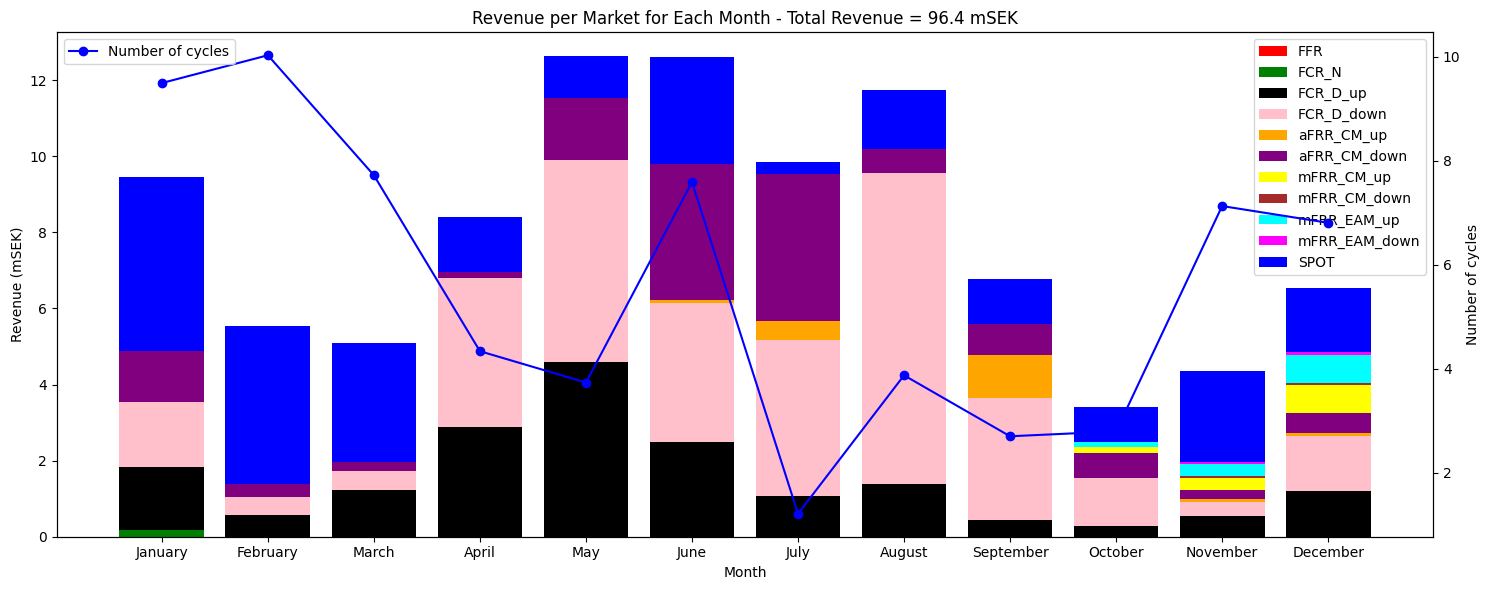

In [114]:
import matplotlib.pyplot as plt

conv_factor = 11.6  # Conversion factor to EUR/SEK

# Calculate the total revenue for all markets
all_results_df['Total_Revenue'] = (
    all_results_df['Revenue_FFR'] 
    + all_results_df['Revenue_FCR_N'] 
    + all_results_df['Revenue_FCR_D_up'] 
    + all_results_df['Revenue_FCR_D_down']
    + all_results_df['Revenue_aFRR_CM_up']  
    + all_results_df['Revenue_aFRR_CM_down']
    + all_results_df['Revenue_mFRR_CM_up']
    + all_results_df['Revenue_mFRR_CM_down']
    + all_results_df['Revenue_mFRR_EAM_up']
    + all_results_df['Revenue_mFRR_EAM_down']

)

if spot_active == 1:
    all_results_df['Total_Revenue'] += all_results_df['Revenue_SPOT']

# Plot stacked bar chart for revenues
plt.figure(figsize=(15, 6))

# Plot each revenue category as a stacked bar
plt.bar(all_results_df['Month'], all_results_df['Revenue_FFR']/1e6*conv_factor, label="FFR", color='red')
plt.bar(all_results_df['Month'], all_results_df['Revenue_FCR_N']/1e6*conv_factor, 
        bottom=all_results_df['Revenue_FFR']/1e6*conv_factor, label="FCR_N", color='green')
plt.bar(all_results_df['Month'], all_results_df['Revenue_FCR_D_up']/1e6*conv_factor, 
        bottom=(all_results_df['Revenue_FFR']+all_results_df['Revenue_FCR_N'])/1e6*conv_factor, label="FCR_D_up", color='black')
plt.bar(all_results_df['Month'], all_results_df['Revenue_FCR_D_down']/1e6*conv_factor, 
        bottom=(all_results_df['Revenue_FFR']+all_results_df['Revenue_FCR_N']+all_results_df['Revenue_FCR_D_up'])/1e6*conv_factor, label="FCR_D_down", color='pink')
plt.bar(all_results_df['Month'], all_results_df['Revenue_aFRR_CM_up']/1e6*conv_factor,
        bottom=(all_results_df['Revenue_FFR']+all_results_df['Revenue_FCR_N']+all_results_df['Revenue_FCR_D_up']+all_results_df['Revenue_FCR_D_down'])/1e6*conv_factor, label="aFRR_CM_up", color='orange')
plt.bar(all_results_df['Month'], all_results_df['Revenue_aFRR_CM_down']/1e6*conv_factor,
        bottom=(all_results_df['Revenue_FFR']+all_results_df['Revenue_FCR_N']+all_results_df['Revenue_FCR_D_up']+all_results_df['Revenue_FCR_D_down']+all_results_df['Revenue_aFRR_CM_up'])/1e6*conv_factor, label="aFRR_CM_down", color='purple')
plt.bar(all_results_df['Month'], all_results_df['Revenue_mFRR_CM_up']/1e6*conv_factor,
        bottom=(all_results_df['Revenue_FFR']+all_results_df['Revenue_FCR_N']+all_results_df['Revenue_FCR_D_up']+all_results_df['Revenue_FCR_D_down']+all_results_df['Revenue_aFRR_CM_up']+all_results_df['Revenue_aFRR_CM_down'])/1e6*conv_factor, label="mFRR_CM_up", color='yellow')
plt.bar(all_results_df['Month'], all_results_df['Revenue_mFRR_CM_down']/1e6*conv_factor,
        bottom=(all_results_df['Revenue_FFR']+all_results_df['Revenue_FCR_N']+all_results_df['Revenue_FCR_D_up']+all_results_df['Revenue_FCR_D_down']+all_results_df['Revenue_aFRR_CM_up']+all_results_df['Revenue_aFRR_CM_down']+all_results_df['Revenue_mFRR_CM_up'])/1e6*conv_factor, label="mFRR_CM_down", color='brown')
plt.bar(all_results_df['Month'], all_results_df['Revenue_mFRR_EAM_up']/1e6*conv_factor,
        bottom=(all_results_df['Revenue_FFR']+all_results_df['Revenue_FCR_N']+all_results_df['Revenue_FCR_D_up']+all_results_df['Revenue_FCR_D_down']+all_results_df['Revenue_aFRR_CM_up']+all_results_df['Revenue_aFRR_CM_down']+all_results_df['Revenue_mFRR_CM_up']+all_results_df['Revenue_mFRR_CM_down'])/1e6*conv_factor, label="mFRR_EAM_up", color='cyan')
plt.bar(all_results_df['Month'], all_results_df['Revenue_mFRR_EAM_down']/1e6*conv_factor,
        bottom=(all_results_df['Revenue_FFR']+all_results_df['Revenue_FCR_N']+all_results_df['Revenue_FCR_D_up']+all_results_df['Revenue_FCR_D_down']+all_results_df['Revenue_aFRR_CM_up']+all_results_df['Revenue_aFRR_CM_down']+all_results_df['Revenue_mFRR_CM_up']+all_results_df['Revenue_mFRR_CM_down']+all_results_df['Revenue_mFRR_EAM_up'])/1e6*conv_factor, label="mFRR_EAM_down", color='magenta')


if spot_active == 1:
    plt.bar(all_results_df['Month'], all_results_df['Revenue_SPOT']/1e6*conv_factor, 
            bottom=(all_results_df['Revenue_FFR']+all_results_df['Revenue_FCR_N']+all_results_df['Revenue_FCR_D_up']+all_results_df['Revenue_FCR_D_down']
                    +all_results_df['Revenue_aFRR_CM_up']+all_results_df['Revenue_aFRR_CM_down']+all_results_df['Revenue_mFRR_CM_up']
                    +all_results_df['Revenue_mFRR_CM_down']+all_results_df['Revenue_mFRR_EAM_up']+all_results_df['Revenue_mFRR_EAM_down'])/1e6*conv_factor, label="SPOT", color='blue')

# Customize labels, title, and legend
plt.xlabel("Month")
plt.ylabel("Revenue (mSEK)")
plt.title("Revenue per Market for Each Month - Total Revenue = "+str(round(all_results_df["Total_Revenue"].sum()*conv_factor/1e6,2))+" mSEK")
plt.legend(loc='upper right')

# Add secondary y-axis for number of cycles
ax2 = plt.gca().twinx()
ax2.plot(all_results_df['Month'], all_results_df['Number_of_cycles']/soc_max, label="Number of cycles", color='blue', marker='o')
ax2.set_ylabel("Number of cycles")
ax2.legend(loc='upper left')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


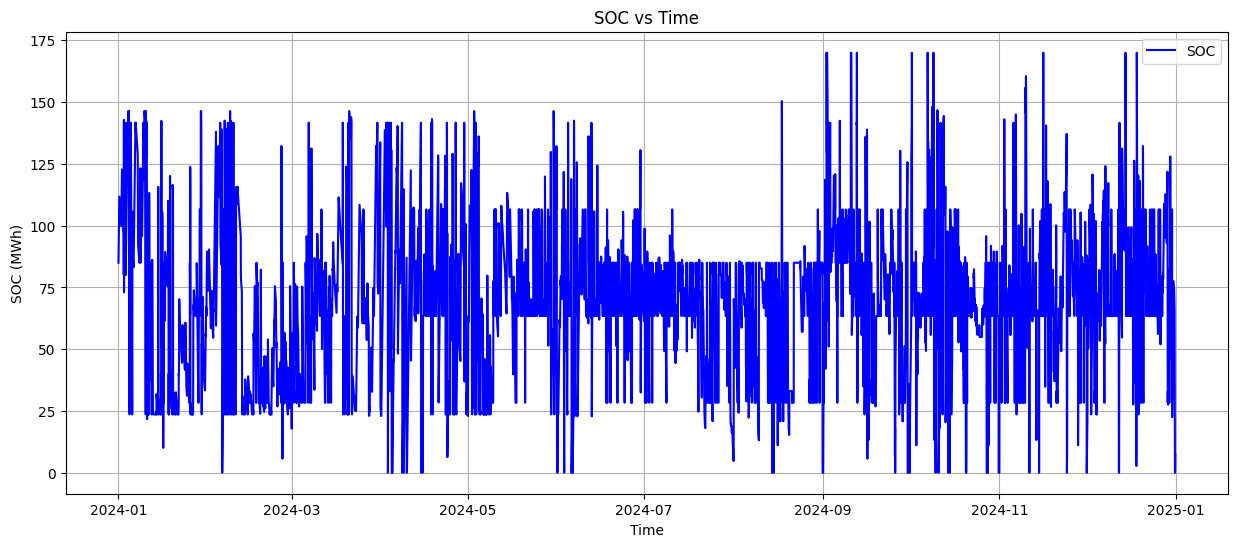

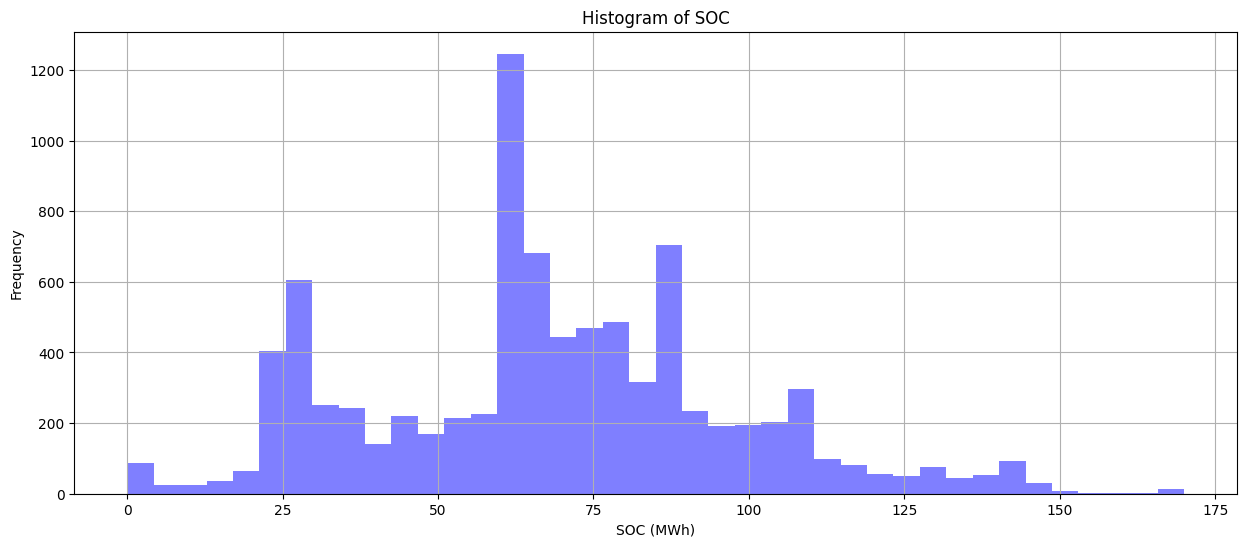

In [111]:
all_months_df = pd.concat(monthly_results.values(), ignore_index=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

conv_factor = 11.6  # Conversion factor to EUR/SEK

# Plot the SOC
ax.plot(all_months_df["Date"], all_months_df["SOC"], label="SOC", color='blue')
ax.set_xlabel("Time")
ax.set_ylabel("SOC (MWh)")
ax.set_title("SOC vs Time")
ax.grid(True)
ax.legend()

# plot the histogram of the SOC 
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.hist(all_months_df["SOC"], bins=40, color='blue', alpha=0.5)
ax.set_xlabel("SOC (MWh)")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of SOC")
ax.grid(True)






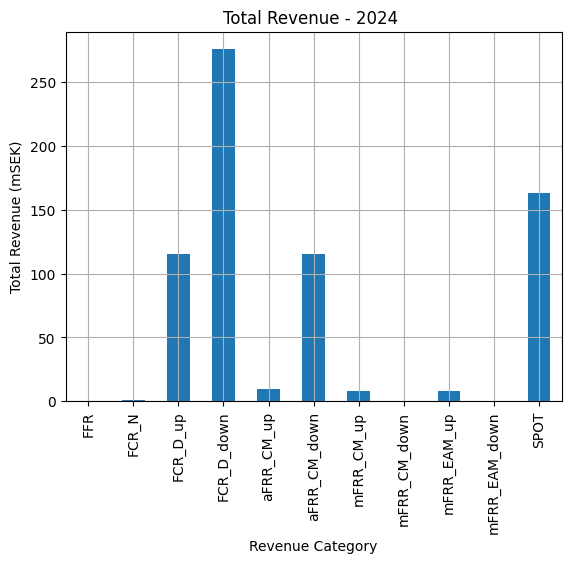

In [103]:
# Assuming the DataFrame is 'df'

# Step 1: Sum the revenue for each category
total_revenue_per_category = all_results_df[['Revenue_FFR', 'Revenue_FCR_N', 'Revenue_FCR_D_up', 'Revenue_FCR_D_down', 'Revenue_aFRR_CM_up', 'Revenue_aFRR_CM_down', 'Revenue_mFRR_CM_up', 'Revenue_mFRR_CM_down', 'Revenue_mFRR_EAM_up', 'Revenue_mFRR_EAM_down', 'Revenue_SPOT']].sum()/1e6*conv_factor
# rename the index
total_revenue_per_category.index = ['FFR', 'FCR_N', 'FCR_D_up', 'FCR_D_down', 'aFRR_CM_up', 'aFRR_CM_down', 'mFRR_CM_up', 'mFRR_CM_down', 'mFRR_EAM_up', 'mFRR_EAM_down', 'SPOT']

# Step 2: Plot the summed revenue as a bar plot
total_revenue_per_category.plot(kind='bar')

# Step 3: Customize the plot
plt.title('Total Revenue - 2024 ')
plt.xlabel('Revenue Category')
plt.ylabel('Total Revenue (mSEK)')
plt.grid()

# Step 4: Show the plot
plt.show()

## Scenario 2: Model with realistic cycle cost

In [4]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd




# Function to run the optimization model for a given month
def run_model_for_month(df_lambda, start_date, end_date, Gmax_disch, soc_min, soc_max, soc_init, delta_FFR, delta_FCR_N, delta_FCR_D,spot_active,FCRD_future,FCRN_future,cycle_cost,etta):
    # Filter the data based on the start and end dates
    df_lambda_month = df_lambda[(df_lambda['Date'] >= start_date) & (df_lambda['Date'] <= end_date)]
    
    # Update the tMax based on the filtered data
    tMax = len(df_lambda_month)
    
    # Create a time index based on the filtered data
    time_index = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # Create a dictionary for Gmax_ch based on the conditions
    Gmax_ch_dict = {}
    for dt in time_index:
        if (4 <= dt.month <= 10) or (22 <= dt.hour or dt.hour < 6) or (dt.weekday() == [5,6]):
            Gmax_ch_dict[dt] = 17
        else:
            Gmax_ch_dict[dt] = 17

    # Map integer time index to datetime objects
    time_index_mapping = {i: dt for i, dt in enumerate(time_index)}

    # define a set of time periods and parameters
    model = ConcreteModel()
    model.T = Set(initialize=range(tMax))
    model.T_order = Set(initialize=time_index, ordered=True)
    model.tamx = Param(initialize=tMax)
    model.Gmax_disch = Param(initialize=Gmax_disch)
    model.Gmax_ch_dict = Param(model.T_order, initialize=Gmax_ch_dict)
    model.soc_min = Param(initialize=soc_min)
    model.soc_max = Param(initialize=soc_max)
    model.delta_FFR = Param(initialize=delta_FFR)
    model.delta_FCR_N = Param(initialize=delta_FCR_N)
    model.delta_FCR_D = Param(initialize=delta_FCR_D)
    model.soc_init = Param(initialize=soc_init)
    model.etta_disch = Param(initialize=etta)
    model.etta_ch = Param(initialize=etta)

    def Gmax_ch_rule(model, t):
        dt = time_index_mapping[t]
        return Gmax_ch_dict[dt]
    model.Gmax_ch = Param(model.T, initialize=Gmax_ch_rule, within=NonNegativeReals)

    # Extract the relevant columns
    lambda_FFR = df_lambda_month['FFR Pris (EUR/MW)'].to_list()
    lambda_FCR_N = df_lambda_month['FCR-N Pris (EUR/MW)'].to_list()
    lambda_FCR_D_up = df_lambda_month['FCR-D upp Pris (EUR/MW)'].to_list()
    lambda_FCR_D_down = df_lambda_month['FCR-D ned Pris (EUR/MW)'].to_list()
    lambda_spot = df_lambda_month['SPOT'].to_list()

    # Create dictionaries for initialization
    lambda_FFR_dict = {t: lambda_FFR[t] for t in model.T}
    lambda_FCR_N_dict = {t: lambda_FCR_N[t] for t in model.T}
    lambda_FCR_D_up_dict = {t: lambda_FCR_D_up[t] for t in model.T}
    lambda_FCR_D_down_dict = {t: lambda_FCR_D_down[t] for t in model.T}
    lambda_spot_dict = {t: lambda_spot[t] for t in model.T}

    # Define the Params in the model
    model.lambda_FFR = Param(model.T, initialize=lambda_FFR_dict)
    model.lambda_FCR_N = Param(model.T, initialize=lambda_FCR_N_dict)
    model.lambda_FCR_D_up = Param(model.T, initialize=lambda_FCR_D_up_dict)
    model.lambda_FCR_D_down = Param(model.T, initialize=lambda_FCR_D_down_dict)
    model.lambda_spot = Param(model.T, initialize=lambda_spot_dict)

    # Define binary decision variables
    model.u_disch = Var(model.T, domain=Binary)
    model.u_ch = Var(model.T, domain=Binary)

    # Define continuous decision variables
    model.p_FFR_disch = Var(model.T, domain=NonNegativeReals)
    # fix p_FF_disch to zero
    model.p_FFR_disch.fix(0)
    model.p_FCR_N = Var(model.T, domain=NonNegativeReals)
    #model.p_FCR_N_ch = Var(model.T, domain=NonNegativeReals)
    model.p_FCR_D_up = Var(model.T, domain=NonNegativeReals)
    model.p_FCR_D_down = Var(model.T, domain=NonNegativeReals)
    model.p_spot_ch = Var(model.T, domain=NonNegativeReals)
    model.p_spot_disch = Var(model.T, domain=NonNegativeReals)
    model.soc = Var(model.T, domain=NonNegativeReals)
    model.cycle_number = Var(model.T, domain=NonNegativeReals)

    # Define the cycle cost 
    

    # Binary variables for SOC(t) intervals
    model.b_soc = Var(model.T, RangeSet(1, intervals), domain=Binary)

    # Binary variables for SOC(t-1) intervals
    model.b_soc_prev = Var(model.T, RangeSet(1, intervals), domain=Binary)
    
    model.costLevel_soc = Var(model.T, domain=NonNegativeReals)

    model.costLevel_soc_prev = Var(model.T, domain=NonNegativeReals)
    model.costPerMWh = Var(model.T, domain=NonNegativeReals)



    # Define the parameters
    model.spot_active = Param(initialize=spot_active)
    model.cycle_cost = Param(initialize=cycle_cost)
    model.FCRD_future = Param(initialize=FCRD_future)
    model.FCRN_future = Param(initialize=FCRN_future)

    ## Define the objective function
    model.obj = Objective(expr=sum(model.lambda_spot[t]*(model.p_spot_disch[t]- model.p_spot_ch[t])*model.spot_active
                                   + model.lambda_FCR_N[t]*model.p_FCR_N[t]*model.FCRN_future 
                                   + model.lambda_FFR[t]*model.p_FFR_disch[t]*0
                                   + model.lambda_FCR_D_down[t]*model.p_FCR_D_down[t]*model.FCRD_future  # capacity payment for FCR_D_down
                                   - model.p_FCR_D_down[t]*model.delta_FCR_D* model.lambda_spot[t]# energy payment for FCR_D_down
                                   + model.p_FCR_D_up[t]*model.delta_FCR_D* model.lambda_spot[t] # energy payment for FCR_D_up
                                   + model.lambda_FCR_D_up[t]*model.p_FCR_D_up[t]*model.FCRD_future 
                                   - model.cycle_cost*model.cycle_number[t]
                                   - model.costPerMWh[t] for t in model.T), sense=maximize) # capacity payment for FCR_D_up
    

    # def p_FCR_D_up_rule(model, t):
    #     return model.p_FCR_D_up[t] <= model.Gmax_disch*model.u_disch[t] 
    # model.p_FCR_D_up_cons = Constraint(model.T, rule=p_FCR_D_up_rule)

    # def p_FCR_D_down_rule(model, t):
    #     return model.p_FCR_D_down[t] <= model.Gmax_disch*model.u_disch[t]
    # model.p_FCR_D_down_cons = Constraint(model.T, rule=p_FCR_D_down_rule)

    # def p_spot_disch_rule(model, t):
    #     return model.p_spot_disch[t] <= model.Gmax_disch*model.u_disch[t]
    # model.p_spot_disch_cons = Constraint(model.T, rule=p_spot_disch_rule)

    # def p_spot_ch_rule(model, t):
    #     return model.p_spot_ch[t] <= model.Gmax_ch[t]*model.u_ch[t]
    # model.p_spot_ch_cons = Constraint(model.T, rule=p_spot_ch_rule)



    ## Define the constraints

    # SOC update constraint
    def soc_update_rule(model, t):
        if t == 0:
            return model.soc[t] == model.soc_init
        else:
            soc_disch = (model.p_FFR_disch[t]*model.delta_FFR + model.p_FCR_N[t]*model.delta_FCR_N + model.p_FCR_D_up[t] * model.delta_FCR_D + model.p_spot_disch[t]*model.spot_active) / model.etta_disch
            soc_ch = (model.p_FCR_N[t]*model.delta_FCR_N + model.p_FCR_D_down[t]*model.delta_FCR_D + model.p_spot_ch[t]*model.spot_active) * model.etta_ch
            return model.soc[t] == model.soc[t-1] + soc_ch - soc_disch
    model.soc_update = Constraint(model.T, rule=soc_update_rule)

    # cycle cost constraint
    # fist we need to calculate the number of cycles for each hour
    def cycle_cost_rule(model, t):
        return model.cycle_number[t] == (model.p_FCR_N[t]*model.delta_FCR_N + model.p_FCR_D_down[t]*model.delta_FCR_D + model.p_spot_ch[t]*model.spot_active
        + model.p_FFR_disch[t]*model.delta_FFR + model.p_FCR_N[t]*model.delta_FCR_N + model.p_FCR_D_up[t] * model.delta_FCR_D + model.p_spot_disch[t]*model.spot_active)#/(model.soc_max-model.soc_min)
    model.cycle_cost_cons = Constraint(model.T, rule=cycle_cost_rule)

    # Capacity constraints
    def ch_power_limit_rule(model, t):
        return model.p_FCR_N[t] + model.p_FCR_D_down[t] + model.p_spot_ch[t]*model.spot_active<= model.Gmax_ch[t]
    model.ch_power_limit = Constraint(model.T, rule=ch_power_limit_rule)

    def disch_power_limit_rule(model, t):
        return model.p_FFR_disch[t] + model.p_FCR_N[t] + model.p_FCR_D_up[t] + model.p_spot_disch[t]*model.spot_active <= model.Gmax_disch
    model.disch_power_limit = Constraint(model.T, rule=disch_power_limit_rule)


    def cap_rule_NEM_up(model, t):
        return 1.34*(model.p_FCR_N[t])+ 1*model.p_FCR_D_up[t] + 0.2*model.p_FCR_D_down[t]  <= Gmax_disch
    model.reserve_rule_fcr_nem_up = Constraint(model.T, rule=cap_rule_NEM_up)

    def cap_rule_NEM_down(model, t):
        return 1.34*(model.p_FCR_N[t])+ 0.2*model.p_FCR_D_up[t] + 1*model.p_FCR_D_down[t]  <= model.Gmax_ch[t]
    model.reserve_rule_fcr_nem_down = Constraint(model.T, rule=cap_rule_NEM_down)



    # Enery balance constraint
    def soc_update_rule_up_end(model, t):
        if t == 0:
            return model.soc[t] == model.soc_init
        else:
            return  model.soc_max - model.soc[t]  >= model.p_FCR_N[t] + 1/3*model.p_FCR_D_down[t] # model.soc_max +
    model.soc_update_2_end = Constraint(model.T, rule=soc_update_rule_up_end)

    # def soc_update_rule_up_begin(model, t):
    #     if t == 0:
    #         return model.soc[t] == model.soc_init
    #     else:
    #         return  model.soc_max - model.soc[t-1]  >= model.p_FCR_N[t] + 1/3*model.p_FCR_D_down[t] # model.soc_max +
    # model.soc_update_2_begin = Constraint(model.T, rule=soc_update_rule_up_begin)

    def soc_update_rule_up_begin(model, t):
        if t == 0:
            return model.soc[t] == model.soc_init
        elif t == 1:
            return model.soc[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_down[t]
        else:
            return  model.soc_max - model.soc[t-1]  >= model.p_FCR_N[t] + 1/3*model.p_FCR_D_down[t] # model.soc_max +
    model.soc_update_2_begin = Constraint(model.T, rule=soc_update_rule_up_begin)

    def soc_update_rule_down_end(model, t):
        if t == 0:
            return model.soc[t] == model.soc_init 
        else:
            return model.soc[t] - model.soc_min >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t]
            #return model.soc[t-1] - model.soc[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t] 
    model.soc_update_3_end = Constraint(model.T, rule=soc_update_rule_down_end)


    # def soc_update_rule_down_begin(model, t):
    #     if t == 0:
    #         return model.soc[t] == model.soc_init
    #     else:
    #         return model.soc[t-1] - model.soc_min >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t]
    #         #return model.soc[t-1] - model.soc[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t] 
    # model.soc_update_3_begin = Constraint(model.T, rule=soc_update_rule_down_begin)



    def soc_update_rule_down_begin(model, t):
        if t == 0:
            return model.soc[t] == model.soc_init
        elif t == 1:
            return model.soc[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t]
        else:
            return model.soc[t-1] - model.soc_min >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t]
            #return model.soc[t-1] - model.soc[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t] 
    model.soc_update_3_begin = Constraint(model.T, rule=soc_update_rule_down_begin)


    # def reserve_rule_FCR_D_upanddown(model, t):
    #     return model.p_FCR_D_up[t] + 0.2* model.p_FCR_D_down[t] <= Gmax_disch
    # model.reserve_rule_fcr_d_upanddown = Constraint(model.T, rule=reserve_rule_FCR_D_upanddown)

    def soc_min_rule(model, t):
        return model.soc[t] >= model.soc_min
    model.soc_min_cons = Constraint(model.T, rule=soc_min_rule)

    def soc_max_rule(model, t):
        return model.soc[t] <= model.soc_max
    model.soc_max_cons = Constraint(model.T, rule=soc_max_rule)





    # SOC interval constraint
    # Binary variables indicating the avg_SOC interval
    # Number of intervals
    intervals = 10

    # SOC thresholds (bounds) in MWh
    soc_max = model.soc_max.value  # Get the value of soc_max
    interval_bounds = [i * 0.1 * soc_max for i in range(intervals + 1)]  # 0%, 10%, ..., 100%

    # Cost levels for each interval (example values)
    cost_levels = {
        1: 20,  # 0% - 10%
        2: 18,  # 10% - 20%
        3: 16,  # 20% - 30%
        4: 15,  # 30% - 40%
        5: 15,  # 40% - 50%
        6: 16,  # 50% - 60%
        7: 18,  # 60% - 70%
        8: 20,  # 70% - 80%
        9: 22,  # 80% - 90%
        10: 25  # 90% - 100%
    }


    # For SOC(t)
    def interval_binary_sum_rule_soc(model, t):
        return sum(model.b_soc[t, i] for i in range(1, intervals + 1)) == 1
    model.interval_binary_sum_soc = Constraint(model.T, rule=interval_binary_sum_rule_soc)

    # For SOC(t-1)
    def interval_binary_sum_rule_soc_prev(model, t):
        return sum(model.b_soc_prev[t, i] for i in range(1, intervals + 1)) == 1
    model.interval_binary_sum_soc_prev = Constraint(model.T, rule=interval_binary_sum_rule_soc_prev)


    # Big M and epsilon
    model.M = Param(initialize=soc_max * 2)  # A large constant
    model.epsilon = Param(initialize=0.01)   # A small positive number

    def soc_lower_bound_rule(model, t, i):
        return model.soc[t] >= interval_bounds[i - 1] + model.epsilon - model.M * (1 - model.b_soc[t, i])
    model.soc_lower_bound = Constraint(model.T, RangeSet(1, intervals), rule=soc_lower_bound_rule)

    def soc_upper_bound_rule(model, t, i):
        return model.soc[t] <= interval_bounds[i] + model.M * (1 - model.b_soc[t, i])
    model.soc_upper_bound = Constraint(model.T, RangeSet(1, intervals), rule=soc_upper_bound_rule)

    
    def soc_prev_lower_bound_rule(model, t, i):
        if t == 0:
            return model.soc_init >= interval_bounds[i - 1] + model.epsilon - model.M * (1 - model.b_soc_prev[t, i])
        else:
            return model.soc[t - 1] >= interval_bounds[i - 1] + model.epsilon - model.M * (1 - model.b_soc_prev[t, i])
    model.soc_prev_lower_bound = Constraint(model.T, RangeSet(1, intervals), rule=soc_prev_lower_bound_rule)

    def soc_prev_upper_bound_rule(model, t, i):
        if t == 0:
            return model.soc_init <= interval_bounds[i] + model.M * (1 - model.b_soc_prev[t, i])
        else:
            return model.soc[t - 1] <= interval_bounds[i] + model.M * (1 - model.b_soc_prev[t, i])
    model.soc_prev_upper_bound = Constraint(model.T, RangeSet(1, intervals), rule=soc_prev_upper_bound_rule)


    # Cost levels for SOC(t)
    
    def cost_level_soc_rule(model, t):
        return model.costLevel_soc[t] == sum(cost_levels[i] * model.b_soc[t, i] for i in range(1, intervals + 1))
    
    model.cost_level_soc_def = Constraint(model.T, rule=cost_level_soc_rule)

    
    # Cost levels for SOC(t-1)
    def cost_level_soc_prev_rule(model, t):
        return model.costLevel_soc_prev[t] == sum(cost_levels[i] * model.b_soc_prev[t, i] for i in range(1, intervals + 1))
    model.cost_level_soc_prev_def = Constraint(model.T, rule=cost_level_soc_prev_rule)

    
    def cost_per_MWh_rule(model, t):
        return model.costPerMWh[t] == 0.5 * (model.costLevel_soc[t] + model.costLevel_soc_prev[t])
    model.cost_per_MWh_def = Constraint(model.T, rule=cost_per_MWh_rule)
     










    # Create a solver
    solver = SolverFactory('glpk')

    # Set the solver options
    solver.options['mipgap'] = 0.08  # This sets the gap to 1%

    # Solve the problem
    results = solver.solve(model, tee=False)

    # Collect the results with rounding to two decimal places
    results_data = {
        "Time": list(model.T),
        "SOC": [round(model.soc[t](), 2) for t in model.T],
        "p_FFR_disch": [round(model.p_FFR_disch[t](), 2) for t in model.T],
        "p_FCR_N": [round(model.p_FCR_N[t](), 2) for t in model.T],
        "p_FCR_D_up": [round(model.p_FCR_D_up[t](), 2) for t in model.T],
        "p_FCR_D_down": [round(model.p_FCR_D_down[t](), 2) for t in model.T],
        "cycle_number": [round(model.cycle_number[t](), 2) for t in model.T],
    }

    if model.spot_active== 1:
        results_data["p_SPOT_disch"] = [round(model.p_spot_disch[t](), 2) for t in model.T]
        results_data["p_SPOT_ch"] = [round(model.p_spot_ch[t](), 2) for t in model.T]

    

    # Calculate revenues for each market and each time steps
    revenue_data = {
        "Time": list(model.T),
        "SOC": [round(model.soc[t](), 2) for t in model.T],
        "Revenue_FFR": [round(lambda_FFR[t] * (model.p_FFR_disch[t]()), 2) for t in model.T],
        "Revenue_FCR_N": [round(lambda_FCR_N[t] * (model.p_FCR_N[t]()), 2) for t in model.T],
        "Revenue_FCR_D_up": [round(lambda_FCR_D_up[t] * model.p_FCR_D_up[t](), 2) for t in model.T],
        "Revenue_FCR_D_down": [round(lambda_FCR_D_down[t] * model.p_FCR_D_down[t](), 2) for t in model.T],
        "Number_of_cycles": [round(model.cycle_number[t](), 2) for t in model.T],
    }

    # for t in model.T:
    #     # print the FCR_D_down capacity payment
    #     print(model.p_FCR_D_up[t](), model.lambda_FCR_D_up[t], model.p_FCR_D_up[t]()*model.lambda_FCR_D_up[t])


    aux={}
    if model.spot_active == 1:
        revenue_data["Revenue_SPOT"] = [round(lambda_spot[t] * (model.p_spot_disch[t]() - model.p_spot_ch[t]()), 2) for t in model.T]
        for t in model.T:
            aux[t]=model.p_spot_disch[t](), model.p_spot_ch[t](), model.lambda_spot[t], model.p_spot_disch[t]()*model.lambda_spot[t] - model.p_spot_ch[t]()*model.lambda_spot[t]


    # Add objective function value per hour
    results_data["Objective_per_hour"] = []
    for t in model.T:
        obj_per_hour = (model.lambda_spot[t]*(model.p_spot_disch[t]() - model.p_spot_ch[t]())*model.spot_active
                        + model.lambda_FCR_N[t]*model.p_FCR_N[t]()*model.FCRN_future
                        + model.lambda_FFR[t]*model.p_FFR_disch[t]()*0
                        + model.lambda_FCR_D_down[t]*model.p_FCR_D_down[t]()*model.FCRD_future
                        - model.p_FCR_D_down[t]()*model.delta_FCR_D*model.lambda_spot[t]
                        + model.p_FCR_D_up[t]()*model.delta_FCR_D*model.lambda_spot[t]
                        + model.lambda_FCR_D_up[t]*model.p_FCR_D_up[t]()*model.FCRD_future
                        - model.cycle_cost*model.cycle_number[t]())
        
        # Append the rounded objective value for each hour
        results_data["Objective_per_hour"].append(round(value(obj_per_hour), 2))


    
    # Create a DataFrame
    revenue_df = pd.DataFrame(revenue_data)
    # Calculate the number of time steps in revenue_df
    num_rows = len(revenue_df)
    date_range = pd.date_range(start=start_date, periods=num_rows, freq='H')
    #date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    # data_range to be same size of revenue_df

    revenue_df['Date'] = date_range

    revenue_df['Month'] = revenue_df['Date'].dt.month
    revenue_df['Year'] = revenue_df['Date'].dt.year
    revenue_df['Day'] = revenue_df['Date'].dt.day
    revenue_df['Hour'] = revenue_df['Date'].dt.hour

    # Mapping from month number to month name
    month_map = {
        1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
        6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',
        11: 'November', 12: 'December'
    }

    # Apply the mapping to the Month column
    revenue_df['Month'] = revenue_df['Month'].map(month_map)

    # Get the unique months present in the data
    unique_months = revenue_df['Month'].unique()

    # Set the Month column as a categorical type with the correct order based on unique months
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']
    # Filter the month_order list to include only the months present in the data
    filtered_month_order = [month for month in month_order if month in unique_months]

    revenue_df['Month'] = pd.Categorical(revenue_df['Month'], categories=filtered_month_order, ordered=True)

    # number of days in the month
    days_in_month = revenue_df['Date'].dt.days_in_month

    # Define the aggregation dictionary based on active_spot
    agg_dict = {
        'Revenue_FFR': 'sum',
        'Revenue_FCR_N': 'sum',
        'Revenue_FCR_D_up': 'sum',
        'Revenue_FCR_D_down': 'sum',
        'Number_of_cycles': 'sum'
    }

    # Include 'Revenue_SPOT' in the aggregation only if active_spot is 1
    if model.spot_active == 1:
        agg_dict['Revenue_SPOT'] = 'sum'

    # Calculate the total revenue for each market service for each month
    revenue_df_month = revenue_df.groupby('Month').agg(agg_dict).reset_index()
    # Calculate the total number of cycles for each month per day
    revenue_df_month['Number_of_cycles'] = revenue_df_month['Number_of_cycles']/days_in_month

    #revenue_df_month=revenue_df.groupby(['Month'])['Revenue_FFR',].sum().reset_index()

    # Create a DataFrame
    results_df = pd.DataFrame(results_data)
    results_df['Date'] = date_range

    # Save aux to a csv file
    # aux = pd.DataFrame(aux)
    # month_name = revenue_df['Month'].unique()[0]


    # aux.to_csv('aux_'+month_name+'.csv')

    return revenue_df_month, results_df


#######################################################################################################################
# Parameters
Gmax_disch = 17             # The maximum discharge power of the battery
soc_min = 0               # The minimum state of charge of the battery (MWh)

# soc_max depends on the battery capacity which are 1-h , 2-h, 4-h or 6-h battery
time_duraion = 1            # x-h battery
soc_max = 17 * time_duraion
soc_init= soc_max/2         # The initial state of charge of the battery

delta_FFR = 0.01            # The activation time of the FFR service per hour
delta_FCR_N = 0.17          # The activation time of the FCR_N service per hour
delta_FCR_D = 0.05          # The activation time of the FCR_D service per hour
 
spot_active = 1             # The activation time of the SPOT service per hour
FCRD_future = 0.0             # The future capacity payment for FCR_D_down
FCRN_future = 0.0            # The future capacity payment for FCR_D_down
cycle_cost = 57          # The cycle cost of the battery (€/MWh)
etta = 0.9                  # The efficiency of the battery


# Main loop to run the model for each month
start_date = pd.to_datetime('2024-01-01 00:00:00')
end_date = pd.to_datetime('2024-08-31 23:00:00')

# Get the price data for each market service (csv file)
df_lambda = pd.read_csv('FCR_data_2024.csv', parse_dates=['Date'])  # Assuming 'Date' is the column with the dates
df_lambda['Date'] = pd.to_datetime(df_lambda['Date'], dayfirst=True)

# Dictionary to hold results for each month
monthly_results = {}


all_results_df = pd.DataFrame()


for month in pd.date_range(start=start_date, end=end_date, freq='MS'):
    month_name = month.strftime('%B')
    start_of_month = month
    end_of_month = month + pd.offsets.MonthEnd(0) + pd.Timedelta(hours=23)
    
    #print("Running the model for the month of: ", month_name)
    #print("The start of the month is: ", start_of_month)
    #print("The end of the month is: ", end_of_month)
    # Run the model for the current month with the updated soc_init
    revenue_df_month, results_df = run_model_for_month(
        df_lambda, 
        start_of_month, 
        end_of_month, 
        Gmax_disch, 
        soc_min, 
        soc_max, 
        soc_init, 
        delta_FFR, 
        delta_FCR_N, 
        delta_FCR_D,
        spot_active,
        FCRD_future,
        FCRN_future,
        cycle_cost,
        etta
    )
    
    # save results_df to a csv file
    # results_df.to_csv('results_df_'+month_name+'.csv')
    # Store the results for the current month
    monthly_results[month_name] = results_df

    
    # Append revenue_df_month to all_results_df
    all_results_df = pd.concat([all_results_df, revenue_df_month], ignore_index=True)   
    
    
    # Update soc_init to be the SOC of the last hour of the current month
    soc_init = results_df['SOC'].iloc[-1]
    #soc_init = results_df['SOC'].iloc[-1]
    #print("The soc_init for the next month is: ", soc_init)
    #df_lambda_month = df_lambda[(df_lambda['Date'] >= start_date) & (df_lambda['Date'] <= end_date)]
    #print("The number of hours in the month is: ", len(df_lambda_month))

# Now `monthly_results` contains a DataFrame for each month, keyed by the month's name.



UnboundLocalError: cannot access local variable 'intervals' where it is not associated with a value